In [15]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import networkx as nx
from functools import lru_cache

In [16]:
#os.environ['PATH'] = '/Users/kenlay/anaconda3/bin:/Users/kenlay/anaconda3/condabin:/opt/local/bin:/opt/local/sbin:/Users/kenlay/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Applications/MATLAB_R2017a.app/bin:/Library/TeX/texbin:/usr/local/share/dotnet:/opt/X11/bin:~/.dotnet/tools:/Library/Frameworks/Mono.framework/Versions/Current/Commands'
#plt.rc('text', usetex=True)

#plt.rc('font', family='serif')
#plt.rc('font', serif='Times')
#plt.rc('font', size=12)
#plt.rc('axes', labelsize=16)

colours = ['#E24A33','#348ABD','#988ED5','#777777','#FBC15E','#8EBA42']
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', colours)

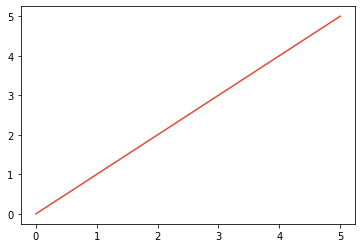

In [17]:
x = np.arange(6)
y = np.arange(6)
plt.plot(x,y)
plt.savefig('figures/deleteme.pdf')

In [18]:
def pivot(df):
    df['dummy']=0
    df = df.pivot(index='dummy',columns='metric', values='value').reset_index(drop=True)
    return df

def get_graph_statistics(graph_string, proportion_perturb, attack, seed):
    fname = f'data/graph_statistics/{graph_string}/{proportion_perturb}_{attack}_{seed}.csv'
    df = pd.read_csv(fname, index_col=0)
    return pivot(df)

def get_denoising_statistics(graph_string, proportion_perturb, snr, attack, seed):
    fname = f'data/denoising_statistics/{graph_string}/{proportion_perturb}_{snr}_{attack}_{seed}.csv'
    df = pd.read_csv(fname, index_col=0)
    return pivot(df)

In [19]:
numeric_columns = ['Eu_added', 'Eu_added_bound', 'Eu_remain', 'Eu_remain_bound',
                   'Eu_removed', 'Eu_removed_bound', 'isolates', 'lap_1dist',
                   'lap_2dist', 'lap_Fdist', 'number_connected_components',
                   'prop_nodes_effected', 'spectrum_l1_dist', 'spectrum_l2_dist',
                   'filter_distance', 'relative_output_distance',
                   'relative_recovery_error_perturbed',
                   'relative_recovery_error_unperturbed', 'snr_in', 'snr_out_perturbed',
                   'snr_out_unperturbed', 'seed', 'degree_std', 'theorem']

In [20]:
@lru_cache(maxsize=None)
def get_df(snr, proportion_perturb, seeds=range(100), valid_only=True):
    graphs = (f'100_BA_3', f'100_ER_0.046', '100_ERA_0.046_0.8', '100_WS_4_0.1', f'100_kreg_3', f'100_knn_3', 'ENZYMES')
    attacks = ('add', 'remove', 'addremove', 'rewire', 'robust', f'pgd_{snr}')
    
    dtype_denoising = {}
    columns = ['lap_2dist', 'lap_1dist', 'number_connected_components', 'isolates', 'snr_in', 'snr_out_unperturbed', 
            'snr_out_perturbed', 'relative_recovery_error_unperturbed',
            'relative_recovery_error_perturbed', 'filter_distance', 'relative_output_distance']
    
    rows = []
    for graph in graphs:
        for attack in attacks:
            for seed in seeds:
                try:
                    gs = get_graph_statistics(graph, proportion_perturb, attack, seed)
                    ds = get_denoising_statistics(graph, proportion_perturb, snr, attack, seed)
                    gsds = pd.concat((gs, ds), axis=1)
                    gsds['graph'] = graph
                    gsds['attack'] = attack
                    gsds['seed'] = seed
                    rows.append(gsds)
                except:
                    pass
                    #print(f'Failed to load df for snr {snr} budget {proportion_perturb} graph {graph} attack {attack} seed {seed}')
    df = pd.concat(rows, axis=0).reset_index(drop=True)
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)
    #df['Eu_remain'][df['Eu_remain'] <  10e-6] = 0 # fixes some numerical issues 
    df.loc[df.Eu_remain <= 10e-6, 'Eu_remain'] = 0.0
    df['fd_over_rod'] =  df['filter_distance']/df['relative_output_distance']
    df['lap_ratio'] = df['lap_1dist']/df['lap_2dist']
    df['bound_remove_loosness'] =  df['Eu_removed_bound'] / df['Eu_removed'] 
    df['bound_added_loosness'] =  df['Eu_added_bound'] / df['Eu_added'] 
    df['bound_remain_loosness'] =  df['Eu_remain_bound'] / df['Eu_remain'] 
    df['bound'] = (df['Eu_removed_bound'] + df['Eu_added_bound'] + df['Eu_remain_bound']) 
    df['bound_loosness'] = (df['Eu_removed_bound'] + df['Eu_added_bound'] + df['Eu_remain_bound']) / (df['Eu_removed'] + df['Eu_added'] + df['Eu_remain'])
    if valid_only:
        df = df.query("is_valid == 'True'")
    return df

In [21]:
graph_remap = {'100_knn_3': '3-NN', 
               '100_kreg_3': '3-Reg', 
               '100_ERA_0.046_0.8': 'Assortative', 
               '100_SBM_2_0.078_0.0078': 'SBM', 
               '100_ER_0.046': 'ER', 
               '100_WS_4_0.1': 'WS', 
               '100_BA_3': 'BA',
               'ENZYMES' : 'ENZYMES'}

perturbation_remap = {'rewire': 'Rewire',
                      'remove': 'Delete',
                      'add': 'Add',
                      'addremove': 'Add/Delete',
                      'robust': 'Robust',
                      'pgd_0.0': 'PGD',
                      'pgd_10.0' : 'PGD'}

In [22]:
snr=0.0
proportion_perturb=0.1
os.makedirs('figures', exist_ok=True)

In [23]:
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
# controls experiments first 
order = ['add', 'remove', 'addremove', 'rewire', 'robust', f'pgd_{snr}'] 
# order by degree variability
hue_order = df.groupby('graph').aggregate('degree_std').median().sort_values().index 
# Control outliers in boxplots
showfliers=False

In [24]:
def make_legend_nice(ax, loc=None):
    handles, _ = ax.get_legend_handles_labels()
    new_handles = [graph_remap[i] for i in hue_order]
    [handle.set_label(label) for handle, label in zip(handles, new_handles)]
    ax.legend(loc=loc, ncol=3, columnspacing=0.5)
    
def make_xaxis_nice(ax):
    xticklabels = [perturbation_remap[label.get_text()] for label in ax.get_xticklabels()]
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Perturbation strategy');
    
def add_grid(ax):
    ax.grid(); 
    ax.set_axisbelow(True);

## Relative output distance and filter distance

#### 5% edges perturbed

ValueError: No objects to concatenate

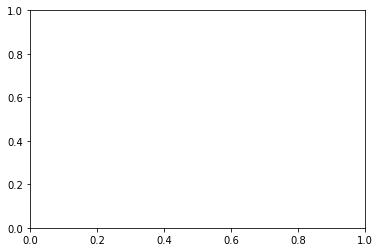

In [25]:
# first plot
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=0.05)
sns.boxplot(x='attack', y='fd_over_rod', hue='graph', data=df, ax=ax, order=order, hue_order=hue_order)

ax.set_ylim(1, 10)
ax.set_ylabel('Filter distance / Relative output distance');
#ax.set_title('Perturbing 5\% of edges');
make_xaxis_nice(ax)
make_legend_nice(ax)
add_grid(ax)
fig.savefig('figures/fd_over_rod_5.pdf', bbox_inches='tight')

#### 10% of edges perturbed

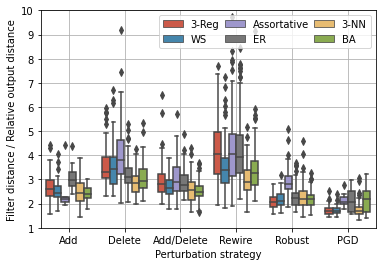

In [26]:
# first plot
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=0.1)
sns.boxplot(x='attack', y='fd_over_rod', hue='graph', data=df, ax=ax, order=order, hue_order=hue_order)

ax.set_ylim(1, 10)
ax.set_ylabel('Filter distance / Relative output distance');
#ax.set_title('Perturbing 10\% of edges');
make_xaxis_nice(ax)
make_legend_nice(ax)
add_grid(ax)
fig.savefig('figures/fd_over_rod_10.pdf', bbox_inches='tight')

## Lipshitz constant (not in the paper)

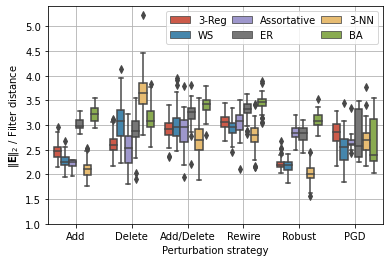

In [27]:
df = get_df(snr=snr, proportion_perturb=0.1)
df['lap_over_filter'] = df['lap_2dist'] / df['filter_distance']
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x='attack', y='lap_over_filter', hue='graph', data=df, ax=ax, order=order, hue_order=hue_order)

ax.set_ylim(1, ax.get_ylim()[1])
make_xaxis_nice(ax)
make_legend_nice(ax)
add_grid(ax)

ax.set_ylabel(r'$\left\Vert \mathbf{E} \right\Vert_2$ / Filter distance');
#ax.set_title('Looseness of operator Lipschitz inequality');

fig.savefig('figures/lipshitz_constant.pdf', bbox_inches='tight')

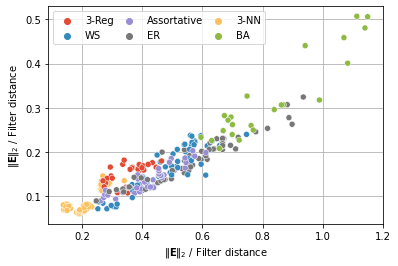

In [28]:
df = get_df(snr=snr, proportion_perturb=0.1, seeds=range(10))
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(x='lap_2dist', y='filter_distance', hue='attack', data=df, ax=ax)

#make_xaxis_nice(ax)
make_legend_nice(ax)
add_grid(ax)

ax.set_xlabel(r'$\left\Vert \mathbf{E} \right\Vert_2$ / Filter distance');
ax.set_ylabel(r'$\left\Vert \mathbf{E} \right\Vert_2$ / Filter distance');
#ax.set_title('Looseness of operator Lipschitz inequality');

fig.savefig('figures/deleteme.pdf', bbox_inches='tight')

## $||E||_2 \leq ||E||_1$

#### Looseness of the inequality

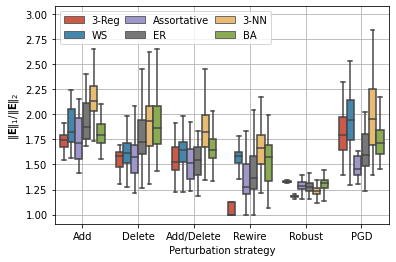

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
sns.boxplot(x='attack', y='lap_ratio', hue='graph', data=df, ax=ax, order=order, hue_order=hue_order, showfliers=showfliers)

# legend and grid
make_legend_nice(ax)
#ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5)).set_title('Graph')
add_grid(ax)
make_xaxis_nice(ax)
ax.set_ylim(ax.get_ylim()[0], 1.05*ax.get_ylim()[1])

# labels
ax.set_ylabel(r'$\left\Vert \mathbf{E} \right\Vert_1 / \left\Vert \mathbf{E} \right\Vert_2$')
ax.set_xlabel('Perturbation strategy')

fig.savefig('figures/holder_b.pdf', bbox_inches='tight')

#### Direct comparison

0.8817592357696905


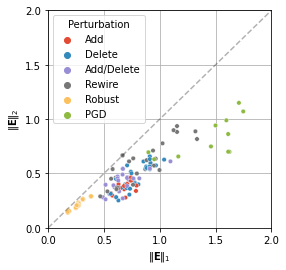

In [30]:
df = get_df(snr=snr, proportion_perturb=proportion_perturb, seeds=range(5))
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='lap_1dist', y='lap_2dist', data=df, ax=ax, hue='attack', s=20)

# figure limites and gridd
#upper = ax.get_xlim()[1]
upper=2
ax.set_xlim(0, upper); ax.set_ylim(0, upper)
ax.plot([0, upper], [0, upper], alpha=0.3, linestyle='dashed', color='black')

# correlation coefficient
corr = np.corrcoef(df['lap_1dist'], df['lap_2dist'])[0][1]
print(corr)
#ax.text(1.1, 1.64, f'Pearson R={corr:.2f}', fontsize=12)

# grid and legend
add_grid(ax)

# legend is different to other plots 
handles, _ = ax.get_legend_handles_labels()
new_handles = [perturbation_remap[i] for i in order]
[handle.set_label(label) for handle, label in zip(handles, new_handles)]
ax.legend().set_title('Perturbation')

# denser ticks
ax.xaxis.set_ticks(np.arange(0, upper+0.01, 0.5))
ax.yaxis.set_ticks(np.arange(0, upper+0.01, 0.5))

# labels and titles
ax.set_xlabel(r'$\left\Vert \mathbf{E} \right\Vert_1$')
ax.set_ylabel(r'$\left\Vert \mathbf{E} \right\Vert_2$')
#ax.set_title(r'Comparison of $\left\Vert \mathbf{E} \right\Vert_1$ and $\left\Vert \mathbf{E} \right\Vert_2$')

fig.savefig('figures/holder_a.pdf', bbox_inches='tight')

## Looseness of the bound on $||E||_1$

#### Remove term

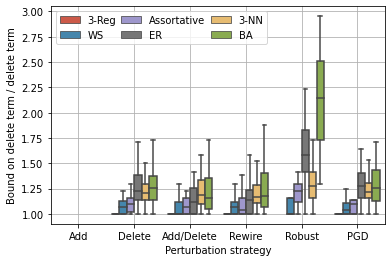

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
sns.boxplot(x='attack', y='bound_remove_loosness', hue='graph', data=df, ax=ax, 
            order=order, hue_order=hue_order, showfliers=showfliers)

#ax.set_ylim(0.95, 2.75)
make_xaxis_nice(ax)
make_legend_nice(ax)
add_grid(ax)
#ax.set_title('Looseness of bound for the remove term')
ax.set_ylabel('Bound on delete term / delete term')
fig.savefig('figures/bound_remove.pdf', bbox_inches='tight')

**Note**
Why is it that 3-Reg/Robust has no bar? Its because the strategy never removes edges around the Eu node. Proof below 

In [32]:
from grapht.graphtools import laplacian
from utils import load_graph, load_perturbed_graph
from src.bound import boundvalid, node_with_largest_Eu

for seed in range(100):
    G = nx.from_scipy_sparse_matrix(load_graph('100_kreg_3', seed))
    Gp = nx.from_scipy_sparse_matrix(load_perturbed_graph('100_kreg_3', 0.1, 'robust', seed))
    if boundvalid(G, Gp):
        L = laplacian(G)
        Lp =  laplacian(Gp)
        E = Lp - L
        Eu_node = node_with_largest_Eu(E)
        subgraph_nodes = list(G.neighbors(Eu_node)) + [Eu_node]
        G = G.subgraph(subgraph_nodes)
        Gp = Gp.subgraph(subgraph_nodes)
        assert set(G.edges).issubset(set(Gp.edges))
        assert len(set(G.edges - Gp.edges)) == 0

ModuleNotFoundError: No module named 'grapht'

#### Add term

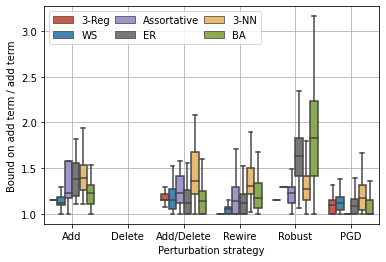

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
sns.boxplot(x='attack', y='bound_added_loosness', hue='graph', data=df, ax=ax, order=order, hue_order=hue_order,  showfliers=showfliers)

#ax.set_ylim(0.95, 2.75)
make_xaxis_nice(ax)
make_legend_nice(ax)
add_grid(ax)
#ax.set_title('Looseness of bound for the add term')
ax.set_ylabel('Bound on add term / add term')
fig.savefig('figures/bound_add.pdf', bbox_inches='tight')

#### Remain term

/Users/henry/anaconda3/envs/perturbation-filter/lib/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


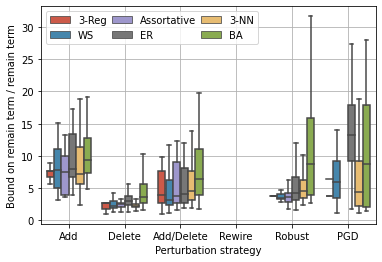

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
sns.boxplot(x='attack', y='bound_remain_loosness', hue='graph', data=df, ax=ax, order=order, hue_order=hue_order,  showfliers=showfliers)

make_xaxis_nice(ax)
make_legend_nice(ax)
add_grid(ax)
#ax.set_title('Looseness of bound for the remain term')
ax.set_ylabel('Bound on remain term / remain term')
fig.savefig('figures/bound_remain.pdf', bbox_inches='tight')

#### Overall term

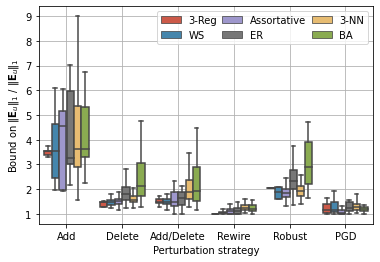

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
sns.boxplot(x='attack', y='bound_loosness', hue='graph', data=df, ax=ax, order=order, hue_order=hue_order,  showfliers=showfliers)


make_xaxis_nice(ax)
#ax.set_ylim(ax.get_ylim()[0], 1.1*ax.get_ylim()[1])
make_legend_nice(ax)
#ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5)).set_title('Graph')
add_grid(ax)
#ax.set_title(r'Looseness of bound for $\left\Vert \mathbf{E} \right\Vert_1$')
ax.set_ylabel(r'Bound on $\left\Vert \mathbf{E}_u \right\Vert_1$ / $\left\Vert \mathbf{E}_u \right\Vert_1$')
fig.savefig('figures/bound_overall.pdf', bbox_inches='tight')

In [54]:
df['bound_loosness'].min()

0.9999999999999997

# Fourth section 

In [55]:
#plt.rc('axes', labelsize=16)

#### Relative output distance

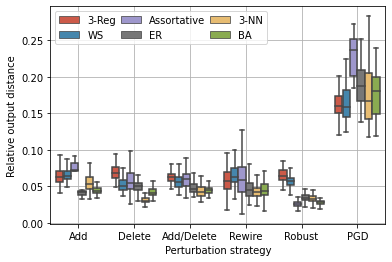

In [36]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
sns.boxplot(x='attack', y='relative_output_distance', hue='graph', data=df, ax=ax,  order=order, hue_order=hue_order, showfliers=showfliers)

make_xaxis_nice(ax)
make_legend_nice(ax)
add_grid(ax)
#ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel('Relative output distance'); 
#ax.set_title('Relative output distance')
fig.savefig('figures/holistic_rod.pdf', bbox_inches='tight')

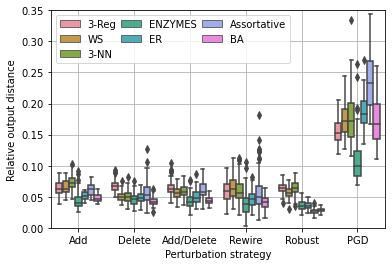

In [103]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
sns.boxplot(x='attack', y='relative_output_distance', hue='graph', data=df, ax=ax,  order=order, hue_order=hue_order)

make_xaxis_nice(ax)
make_legend_nice(ax, loc=2)
add_grid(ax)
ax.set_ylim(0.0, 0.35)
ax.set_ylabel('Relative output distance'); 
#ax.legend().remove()
#ax.set_title('Relative output distance')
fig.savefig('figures/holistic_rod.pdf', bbox_inches='tight')

#### Filter distance

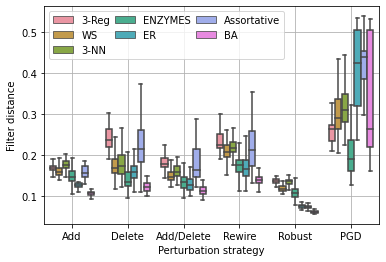

In [88]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
sns.boxplot(x='attack', y='filter_distance', hue='graph', data=df, ax=ax,  order=order, hue_order=hue_order, showfliers=showfliers)

make_xaxis_nice(ax)
make_legend_nice(ax)
add_grid(ax)
#ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel('Filter distance'); 
#ax.set_title('Filter distance')
fig.savefig('figures/holistic_filter.pdf', bbox_inches='tight')

#### $||E||_2$

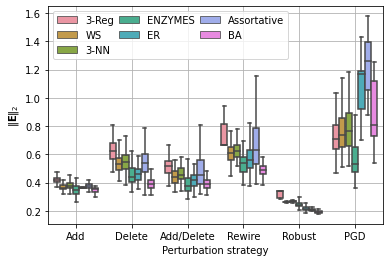

In [89]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
sns.boxplot(x='attack', y='lap_2dist', hue='graph', data=df, ax=ax,  order=order, hue_order=hue_order, showfliers=showfliers)

make_xaxis_nice(ax)
make_legend_nice(ax)
add_grid(ax)
#ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel(r'$\left\Vert \mathbf{E} \right\Vert_2$'); 
#ax.set_title('Error norm (2-norm)')
fig.savefig('figures/holistic_E2.pdf', bbox_inches='tight')

#### $||E||_1$

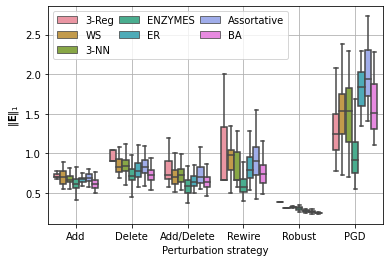

In [90]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
sns.boxplot(x='attack', y='lap_1dist', hue='graph', data=df, ax=ax,  order=order, hue_order=hue_order, showfliers=showfliers)

make_xaxis_nice(ax)
make_legend_nice(ax)
add_grid(ax)
#ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel(r'$\left\Vert \mathbf{E} \right\Vert_1$'); 
#ax.set_title('Error norm (1-norm)')
fig.savefig('figures/holistic_E1.pdf', bbox_inches='tight')

#### Final bound

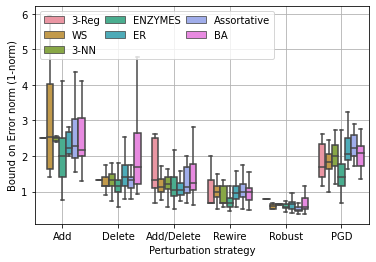

In [91]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
sns.boxplot(x='attack', y='bound', hue='graph', data=df, ax=ax,  order=order, hue_order=hue_order, showfliers=showfliers)

make_xaxis_nice(ax)
make_legend_nice(ax, loc=2)
add_grid(ax)
#ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.1)
ax.set_ylabel('Bound on Error norm (1-norm)'); 
#ax.set_title('Overall bound')
fig.savefig('figures/holistic_bound.pdf', bbox_inches='tight')

ylim_from_old = ax.get_ylim()

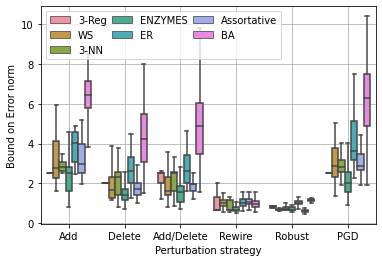

In [92]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
sns.boxplot(x='attack', y='theorem', hue='graph', data=df, ax=ax,  order=order, hue_order=hue_order, showfliers=showfliers)

make_xaxis_nice(ax)
make_legend_nice(ax, loc=2)
add_grid(ax)
#ax.set_ylim(*ylim_from_old)
ax.set_ylabel('Bound on Error norm'); 
#ax.set_title('Overall bound')
fig.savefig('figures/holistic_theorem.pdf', bbox_inches='tight')

### Theorem bound

In [39]:
df.columns

Index(['Eu_added', 'Eu_added_bound', 'Eu_remain', 'Eu_remain_bound',
       'Eu_removed', 'Eu_removed_bound', 'degree_std', 'is_valid', 'isolates',
       'lap_1dist', 'lap_2dist', 'lap_Fdist', 'number_connected_components',
       'prop_nodes_effected', 'spectrum_l1_dist', 'spectrum_l2_dist',
       'theorem', 'filter_distance', 'relative_output_distance',
       'relative_recovery_error_perturbed',
       'relative_recovery_error_unperturbed', 'snr_in', 'snr_out_perturbed',
       'snr_out_unperturbed', 'graph', 'attack', 'seed', 'fd_over_rod',
       'lap_ratio', 'bound_remove_loosness', 'bound_added_loosness',
       'bound_remain_loosness', 'bound', 'bound_loosness', 'lap_over_filter'],
      dtype='object', name='metric')

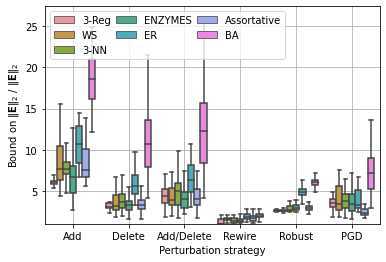

In [93]:
fig, ax = plt.subplots(figsize=(6, 4))
df = get_df(snr=snr, proportion_perturb=proportion_perturb)
df['theoremlooseness'] = df['theorem']/df['lap_2dist']
sns.boxplot(x='attack', y='theoremlooseness', hue='graph', data=df, ax=ax,  order=order, hue_order=hue_order, showfliers=showfliers)

make_xaxis_nice(ax)
make_legend_nice(ax, loc=2)
add_grid(ax)
ax.set_ylim(1, ax.get_ylim()[1])
ax.set_ylabel(r'Bound on $\left\Vert \mathbf{E} \right\Vert_2$ / $\left\Vert \mathbf{E} \right\Vert_2$')
#ax.set_title('Overall bound')
fig.savefig('figures/theorem1_looseness.pdf', bbox_inches='tight')

In [41]:
df.query('theoremlooseness==1')['attack']

Series([], Name: attack, dtype: object)

In [42]:
np.arange(1, ax.get_ylim()[1], 4)

array([ 1.,  5.,  9., 13., 17., 21.])

### Validness

In [94]:
df = get_df(snr=snr, proportion_perturb=proportion_perturb, valid_only=False)
df_sub = df[['attack', 'graph', 'is_valid']]
df_sub['is_valid'] = (df_sub['is_valid']=='True').astype('float')
df_sub = df_sub.groupby(['attack', 'graph'], as_index=False).aggregate('is_valid').mean()

<ipython-input-94-eb6ddfb379bd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['is_valid'] = (df_sub['is_valid']=='True').astype('float')


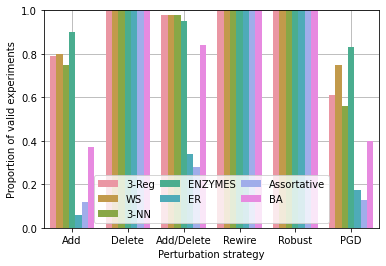

In [95]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='attack', y='is_valid', hue='graph', data=df_sub, ax=ax, order=order, hue_order=hue_order)

make_xaxis_nice(ax)
make_legend_nice(ax, loc=8)
add_grid(ax)
ax.set_ylim(0, 1)
ax.set_ylabel(r'Proportion of valid experiments')
#ax.set_title('Overall bound')
fig.savefig('figures/is_valid.pdf', bbox_inches='tight')

## Graph analysis

In [2]:
from utils import load_graph, load_perturbed_graph
import matplotlib.lines as mlines

In [3]:
node_size = 4
edge_width=1
blue = (0, 0.4470, 0.7410)
red = (0.8500, 0.3250, 0.0980)

def plot_perturbation(G, Gp, ax, pos):
    removed = removed_edges(G, Gp)
    added = added_edges(G, Gp)
    other = set(G.edges()) - removed
    nx.draw_networkx_nodes(G, pos=pos, node_color='black', node_size=[node_size*(G.degree(i)**1.5) for i in G.nodes()], ax=ax)
    nx.draw_networkx_edges(G, pos=pos, edgelist=added, edge_color=[blue]*len(added), width=edge_width, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, edgelist=removed, edge_color=[red]*len(removed), width=edge_width, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, edgelist=other, edge_color='black', width=edge_width, alpha=0.1, ax=ax)
    
def weighted_spring_layout(G, Gp1, Gp2, weight=5):
    removed = removed_edges(G, Gp1).union(removed_edges(G, Gp2))
    added = added_edges(G, Gp1).union(added_edges(G, Gp2))
    
    G_pos = G.copy()
    G_pos.add_edges_from(added)
    for edge in G_pos.edges():
        if edge in added or edge in removed:
            u, v = edge
            G_pos[u][v]['weight'] = weight
    pos = nx.spring_layout(G_pos)
    return pos

def removed_edges(G, Gp):
    return set(G.edges()) - set(Gp.edges())

def added_edges(G, Gp):
    return set(Gp.edges()) - set(G.edges())

def ws4_layout(G, stretch=1.1):
    n = G.number_of_nodes()
    pos = {}
    for i in range(n):
        x, y = np.cos(i * 2 * np.pi / n), np.sin(i * 2 * np.pi / n)
        if i%2 == 0:
            x, y = stretch * x, stretch * y
        pos.update({i : np.array([x, y])})
    return pos

In [4]:
def plot_graphs(Gp_pgd, Gp_rob, pos):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    plot_perturbation(G, Gp_pgd, ax1, pos)
    plot_perturbation(G, Gp_rob, ax2, pos)
    fig.subplots_adjust(wspace=0.05)
    ax1.axis('off'); ax2.axis('off'); 
    ax1.set_title('PGD'); ax2.set_title('Robust')
    blue_line = mlines.Line2D([], [], color=[0, 0.4470, 0.7410], label='Edge addition')
    red_line = mlines.Line2D([], [], color=[0.8500, 0.3250, 0.0980], label='Edge deletion')
    ax1.legend(handles=[blue_line, red_line], loc=2)
    return fig, (ax1, ax2)

In [5]:
graph_remap = {'100_knn_3': '3-NN', 
               '100_kreg_3': '3-Reg', 
               '100_ERA_0.046_0.8': 'Assortative', 
               '100_SBM_2_0.078_0.0078': 'SBM', 
               '100_ER_0.046': 'ER', 
               '100_WS_4_0.1': 'WS', 
               '100_BA_3': 'BA',
               'ENZYMES': 'ENZYMES'}

In [6]:
graph_string = '50_kreg_3'
seed=3
perturbation=0.1
G = nx.from_scipy_sparse_matrix(load_graph(graph_string, seed))
Gp_pgd = nx.from_scipy_sparse_matrix(load_perturbed_graph(graph_string, perturbation, 'pgd_0.0', seed))
Gp_rob = nx.from_scipy_sparse_matrix(load_perturbed_graph(graph_string, perturbation, 'robust', seed))
pos = weighted_spring_layout(G, Gp_pgd, Gp_rob)
fig, axs = plot_graphs(Gp_pgd, Gp_rob, pos)
#fig.suptitle('3-Reg')
plt.savefig('figures/kreg_example.pdf', bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'data/graphs/50_kreg_3/3.npz'

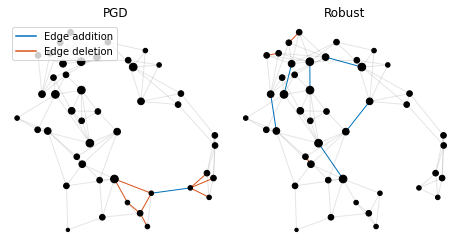

In [142]:
graph_string = 'ENZYMES'
seed=12
perturbation=0.1
G = nx.from_scipy_sparse_matrix(load_graph(graph_string, seed))
Gp_pgd = nx.from_scipy_sparse_matrix(load_perturbed_graph(graph_string, perturbation, 'pgd_0.0', seed))
Gp_rob = nx.from_scipy_sparse_matrix(load_perturbed_graph(graph_string, perturbation, 'robust', seed))
pos = weighted_spring_layout(G, Gp_pgd, Gp_rob)
fig, axs = plot_graphs(Gp_pgd, Gp_rob, pos)
#fig.suptitle('3-Reg')
#plt.savefig('figures/ENYZMES.pdf', bbox_inches='tight')

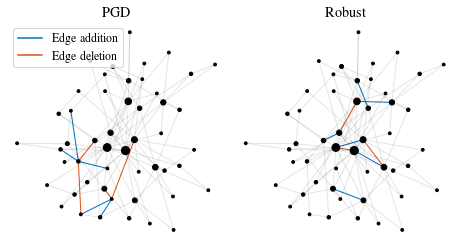

In [68]:
graph_string = '50_BA_2'
seed=2
perturbation=0.1
G = nx.from_scipy_sparse_matrix(load_graph(graph_string, seed))
Gp_pgd = nx.from_scipy_sparse_matrix(load_perturbed_graph(graph_string, perturbation, 'pgd_0.0', seed))
Gp_rob = nx.from_scipy_sparse_matrix(load_perturbed_graph(graph_string, perturbation, 'robust', seed))
pos = weighted_spring_layout(G, Gp_pgd, Gp_rob, 2)
fig, axs = plot_graphs(Gp_pgd, Gp_rob, pos)
#fig.suptitle('Barabási Albert')
plt.savefig('figures/BA_example.pdf', bbox_inches='tight')

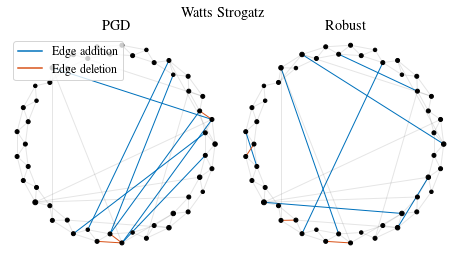

In [42]:
graph_string = '50_WS_4_0.1'
seed=2
perturbation=0.1
G = nx.from_scipy_sparse_matrix(load_graph(graph_string, seed))
Gp_pgd = nx.from_scipy_sparse_matrix(load_perturbed_graph(graph_string, perturbation, 'pgd_0.0', seed))
Gp_rob = nx.from_scipy_sparse_matrix(load_perturbed_graph(graph_string, perturbation, 'robust', seed))
pos = ws4_layout(G)
fig, axs = plot_graphs(Gp_pgd, Gp_rob, pos)
fig.suptitle('Watts Strogatz')
plt.savefig('figures/WS_example.pdf', bbox_inches='tight')

In [9]:
graph_string = '50_ERA_0.0782_0.8'
seed=0
perturbation=0.1
G = nx.from_scipy_sparse_matrix(load_graph(graph_string, seed))
Gp_pgd = nx.from_scipy_sparse_matrix(load_perturbed_graph(graph_string, perturbation, 'pgd_0.0', seed))
Gp_rob = nx.from_scipy_sparse_matrix(load_perturbed_graph(graph_string, perturbation, 'robust', seed))
pos = weighted_spring_layout(G, Gp_pgd, Gp_rob, 2)
fig, axs = plot_graphs(Gp_pgd, Gp_rob, pos)
fig.suptitle('Assortative')
#plt.savefig('figures/ERA_example.pdf', bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'data/graphs/50_ERA_0.0782_0.8/0.npz'

Text(0.5, 0.98, 'Assortative')

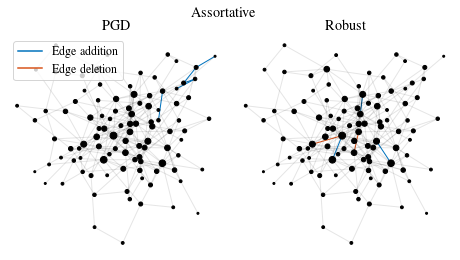

In [44]:
graph_string = '100_ER_0.046'
seed=0
perturbation=0.025
G = nx.from_scipy_sparse_matrix(load_graph(graph_string, seed))
Gp_pgd = nx.from_scipy_sparse_matrix(load_perturbed_graph(graph_string, perturbation, 'pgd_0.0', seed))
Gp_rob = nx.from_scipy_sparse_matrix(load_perturbed_graph(graph_string, perturbation, 'robust', seed))
pos = weighted_spring_layout(G, Gp_pgd, Gp_rob, 2)
fig, axs = plot_graphs(Gp_pgd, Gp_rob, pos)
fig.suptitle('Assortative')
#plt.savefig('figures/ERA_example.pdf', bbox_inches='tight')

### Appendix figure

In [1]:
import matplotlib.cm as cm
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt

Text(2.2, 4.7, '$(d_u+\\alpha d_u, d_v + \\alpha d_v)$')

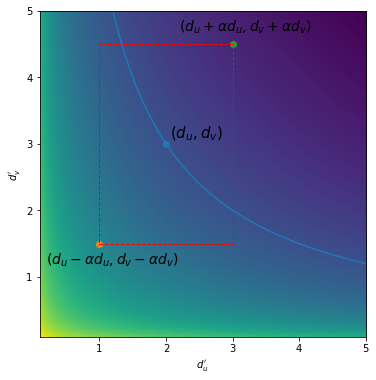

In [2]:
# set up figure
fig, ax = plt.subplots(figsize=(6, 6))

### make contour plot background
delta = 0.025

xlim = (0.1, 5)
ylim = (0.1, 5)

x = np.arange(*xlim, delta)
y = np.arange(*ylim, delta)
X, Y = np.meshgrid(x, y)
Z = 1/np.sqrt(X*Y)

im = ax.imshow(np.log(np.log(Z+1)), interpolation='bilinear', origin='lower', extent=(xlim[0], xlim[1], ylim[0], ylim[1]))

### show where f is defined
du = 2
dv = 3
alpha = 0.5

xlower = du - alpha*du
ylower = dv - alpha*dv
xupper = du + alpha*du
yupper = dv + alpha*dv
xlength = xupper - xlower
ylength = yupper - ylower
rect = patches.Rectangle((xlower,ylower),xlength,ylength,linewidth=1,edgecolor='r',linestyle='--',facecolor='none')

ax.add_patch(rect)

### zeros of f 
dudash = np.arange(0.1, 5, 0.01)
dvdash = du*dv/dudash
plt.plot(dudash, dvdash)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

# labels
ax.set_xlabel(r"$d_u'$")
ax.set_ylabel(r"$d_v'$")

ax.scatter(du, dv)
coord = np.array([du, dv])
ax.annotate(r"$(d_u, d_v)$", coord, xytext=1.03*coord, fontsize=15)

ax.scatter(xlower, ylower)
coord = np.array([xlower, ylower])
ax.annotate(r"$(d_u-\alpha d_u, d_v - \alpha d_v)$", coord, xytext=(0.2,1.2), fontsize=14)

ax.scatter(xupper, yupper)
coord = np.array([xupper, yupper])
ax.annotate(r"$(d_u+\alpha d_u, d_v + \alpha d_v)$", coord, xytext=(2.2, 4.7), fontsize=14)

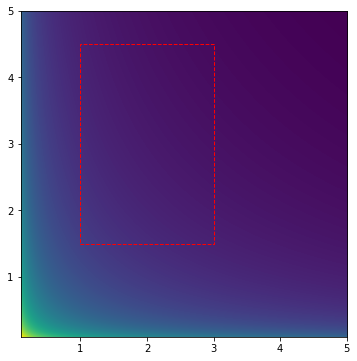

In [143]:
fig

In [124]:
xlength

4.800000000000001

In [15]:
import networkx as nx


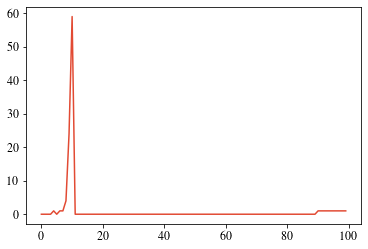

In [25]:
plt.plot(nx.degree_histogram(nx.barabasi_albert_graph(100, 90)))